In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, pretend = (True, 'project_office') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if pretend == 'manual':
    manual = True

In [2]:
import geopandas as gpd
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [4]:
import rasterio
from visualization import add_raster, add_north, add_scalebar, add_north_and_scalebar
raster= rasterio.open(r'../../inputs/tiff/20137.tiff')

In [5]:
growth = pd.read_excel(
    '../../inputs/parameters.xlsx',
    usecols=['category', 'parameter', 'base', 'bipolar', 'scattered', 'polycentric'],
    index_col=[0,1]
).loc['population_growth'].T

# RENAME COLUMNS
urban_shape = pd.read_excel(
    '../../inputs/parameters.xlsx',
    usecols=['category', 'parameter', 'base', 'bipolar', 'scattered', 'polycentric'],
    index_col=[0,1]
).loc['general', 'urban_shape' ].to_dict()
growth = growth.rename(index=urban_shape)
growth

parameter        existing_high existing_low existing_vacant reserved    open  \
2020                         0            0               0        0       0   
Two Cities               78546        98678           36000        0  122375   
Scattered City           29455         6382           76563        0  283200   
Polycentric City         78546       102933           60000        0  154121   

parameter            nip  
2020                   0  
Two Cities        180000  
Scattered City    120000  
Polycentric City  120000

In [6]:
zones = gpd.read_file('../../inputs/zones/zones_project.geojson')

In [7]:
import string

In [8]:
def format_string(s):
    
    try: 
        s = s.replace('é', 'e').replace(' ', '_')
        return ''.join(i for i in s if i in string.printable)
    except:
        return s

In [9]:
latin_columns = ['latin', 'latin_code', 'latin_name', 'kebele_latin']
zones[latin_columns] = zones[latin_columns].applymap(format_string)

In [10]:
#zones['polycentric'] = zones['polycentric'].fillna(0).astype(bool).astype(int)

In [11]:
zones = zones.to_crs(epsg='20137')

In [12]:
#A vérifier avec Quentin

pop_base_excel = 319476
pop_base_model = zones['population'].sum()

zones['population'] = zones['population']*pop_base_excel/pop_base_model

In [13]:
zone_to_type = {
    '3' : 'existing_high',
    '1' : 'nip',
    '4' : 'reserved',
    '2' : 'existing_low',
    '5' : 'open_central',
    '6' : 'open_peripheric',
    '7' : 'existing_vacant'
    
}
type_to_type ={
    'open_central': 'open',
    'open_peripheric': 'open'    
}
zones['type'] = zones['zone'].apply(lambda z: type_to_type.get(zone_to_type[z], zone_to_type[z]))

zones['Two Cities'] = (1 - zones['bipolar'].fillna(0)).astype(int)
zones['Polycentric City'] = (1 - zones['polycentric'].fillna(0).astype(bool).astype(int)).astype(int)
zones['Compact City'] = zones['Polycentric City']
zones['Scattered'] = zones['Two Cities']
zones['Worst Scattered'] = zones['Two Cities']
zones['Scattered City'] = zones['Two Cities']

zones['area'] = zones['geometry'].apply(lambda g: g.area) / 1e6

In [14]:
import numpy as np

In [15]:
zones['max_density'] = zones['type'].apply(lambda t: {'existing_high': 16000}.get(t, 15000))
zones['pop_density'] = (zones['population'] / zones['area'] ).fillna(0)
zones['Population Density 2020'] = zones['pop_density']
zones['Population 2020'] = zones['population']
zones['growth_potential'] = np.clip(zones['max_density'] * zones['area'] - zones['population'].fillna(0), 0, None)

In [16]:
z = zones.copy()
z.loc[(z['growth_potential'] == 0) & (z['Population Density 2020'] == 0)][['type', 'area']]

Empty DataFrame
Columns: [type, area]
Index: []

In [17]:
def grow(zones, growth_series, central_dummy='central', priority=1):
    zones['growth_potential'] = np.clip(zones['max_density'] * zones['area'] - zones['population'].fillna(0), 0, None)
    zones = zones.copy()
    if central_dummy == 'Polycentric City':
        zones.loc[zones['polycentric'] == 2, 'growth_potential'] = 0
    zones['central'] = zones[central_dummy]
    zones['central'] = zones['central'].apply({1: 'central', 0: 'peripheric'}.get)

    df = zones.groupby(['central', 'type'])[['area', 'population', 'growth_potential']].sum()
    potential = df[['growth_potential']].unstack(('central')).fillna(0)
    

    potential['total'] = growth_series
    p = potential.copy()
    
    p[ 'centrality'] = (p['growth_potential','central'] * priority)  \
        /(p['growth_potential','central'] * priority + p['growth_potential','peripheric'])
    p['issue'] =np.clip( p['total'] - p['growth_potential'].sum(axis=1), 0, None)
    p['growth', 'central'] = pd.DataFrame(
        [p['centrality']*p[ 'total'], p['growth_potential','central']]).min()
    p['growth', 'peripheric'] = pd.DataFrame([p['total'] - p['growth', 'central'], p['growth_potential','peripheric']]).min()
    for where in 'central', 'peripheric':
        p['development',where] = (p['growth', where] / p['growth_potential', where]).fillna(0)
    p[['growth_potential', 'growth', 'development', 'total', 'issue']]
    p['growth_potential', 'total'] = p['growth_potential'].sum(axis=1)
    
    big = ['total','issue', 'growth_potential',  'growth']
    percent = [ 'development']
    summary = pd.concat(
        [
            np.round(p[big], -2).astype(int),
            np.round(p[percent]*100).astype(int).astype(str) + '%'
        ],
        axis=1
    )
    dev_dict = p['development'].stack().to_dict()
    z = zones.set_index(['central', 'type'], drop=False)
    zones['development'] = zones.apply(lambda z: dev_dict[(z['type'], z['central'])], axis=1)
    zones['pop_growth'] = zones['development'] * zones['growth_potential']
    zones['pop_growth'].sum()

    zones['population_2040'] = zones['population'].fillna(0) + zones['pop_growth']
    zones['population_density_2040'] = np.round(zones['population_2040'] / zones['area'], -2).astype(int)
    return zones, summary
def prettify(ax):
    add_raster(ax, raster, keep_ax_limits=True)
    add_north(ax)
    add_scalebar(ax)
    ax.set_yticks([])
    ax.set_xticks([])
    
def plot_density(
    zones, column='population_density_2040', cmap='YlOrRd', scheme='UserDefined', ax=None, legend=True, 
    bins=[1000,2000, 5000, 10000, 15000, 25000]):
    dummy = zones.iloc[0].copy()
    dummy[column] = 0
    
    #zones = zones.loc[zones[column]>= bins[0]]
    
    cax = None
    if scheme is None:
        fig, ax = plt.subplots(1, 1, figsize=(17, 7))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.05)
        
    ax = zones.append(dummy).plot(
        column=column, figsize=(17, 7), legend=legend, 
        cmap=cmap, scheme=scheme, classification_kwds={'bins': bins}, # scheme='UserDefined',
        alpha=0.67, ax=ax, cax=cax
    )
    prettify(ax)
    try:
        leg = ax.get_legend()
        for t in leg.get_texts():
            t.set_text(t.get_text().replace('.00', ''))
        leg.set_bbox_to_anchor((1, 0.35, 0.0, 0.))
        leg.set_title('Population Density hab / km²')
    except AttributeError:
        pass

    return ax

In [18]:
to_concat = []
keys = []

for scen, priority in [('Polycentric City', 1000000), ( 'Two Cities', 1000000), ('Scattered City', 1)]:
    growth_scenario = growth.loc[scen]
    zones, summary = grow(zones, growth_scenario, scen, priority=priority)
    zones['Population ' + scen] = zones['population_2040'] 
    zones['Population Density ' + scen] = zones['population_density_2040']
    to_concat.append(summary)
    keys.append(scen)
summaries = pd.concat(to_concat, keys=keys)
summaries.index.names = ['scenario', 'type']
summaries.columns.names = ['indicator', 'zone']

In [19]:
summaries

indicator                          total issue growth_potential             \
zone                                                    central peripheric   
scenario         type                                                        
Polycentric City existing_high     78546     0           124700       8400   
                 existing_low     102933     0            68500      34700   
                 existing_vacant   60000     0           165100       7200   
                 nip              120000     0           150900     339500   
                 open             154121     0            45900     223100   
                 reserved              0     0            58800      66300   
Two Cities       existing_high     78546     0           133000          0   
                 existing_low      98678     0            71900      31300   
                 existing_vacant   36000     0           144200      28200   
                 nip              180000     0           281800     334000   
                 open             122375     0           255700     639100   
                 reserved              0     0            81700      43300   
Scattered City   existing_high     29455     0           133000          0   
                 existing_low       6382     0            71900      31300   
                 existing_vacant   76563     0           144200      28200   
                 nip              120000     0           281800     334000   
                 open             283200     0           255700     639100   
                 reserved              0     0            81700      43300   

indicator                                 growth            development  \
zone                               total central peripheric     central   
scenario         type                                                     
Polycentric City existing_high    133000   78500          0         63%   
                 existing_low     103200   68500      34400        100%   
                 existing_vacant  172300   60000          0         36%   
                 nip              490400  120000          0         80%   
                 open             269000   45900     108200        100%   
                 reserved         125100       0          0          0%   
Two Cities       existing_high    133000   78500          0         59%   
                 existing_low     103200   71900      26800        100%   
                 existing_vacant  172300   36000          0         25%   
                 nip              615800  180000          0         64%   
                 open             894800  122400          0         48%   
                 reserved         125100       0          0          0%   
Scattered City   existing_high    133000   29500          0         22%   
                 existing_low     103200    4400       1900          6%   
                 existing_vacant  172300   64000      12500         44%   
                 nip              615800   54900      65100         19%   
                 open             894800   80900     202300         32%   
                 reserved         125100       0          0          0%   

indicator                                    
zone                             peripheric  
scenario         type                        
Polycentric City existing_high           0%  
                 existing_low           99%  
                 existing_vacant         0%  
                 nip                     0%  
                 open                   49%  
                 reserved                0%  
Two Cities       existing_high           0%  
                 existing_low           86%  
                 existing_vacant         0%  
                 nip                     0%  
                 open                    0%  
                 reserved                0%  
Scattered City   existing_high           0%  
                 existing_low            6%  
   

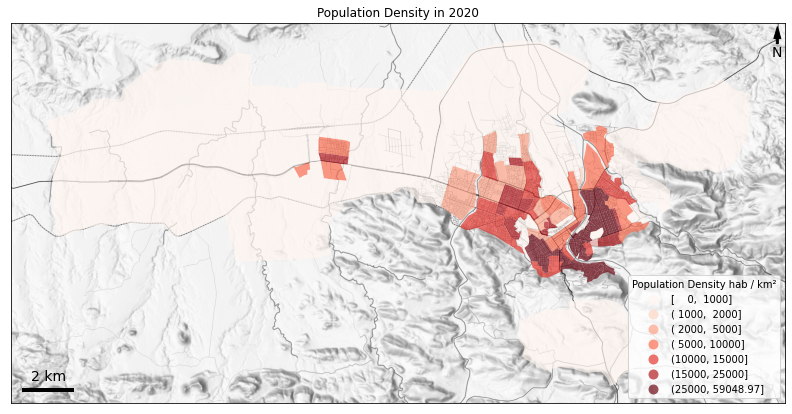

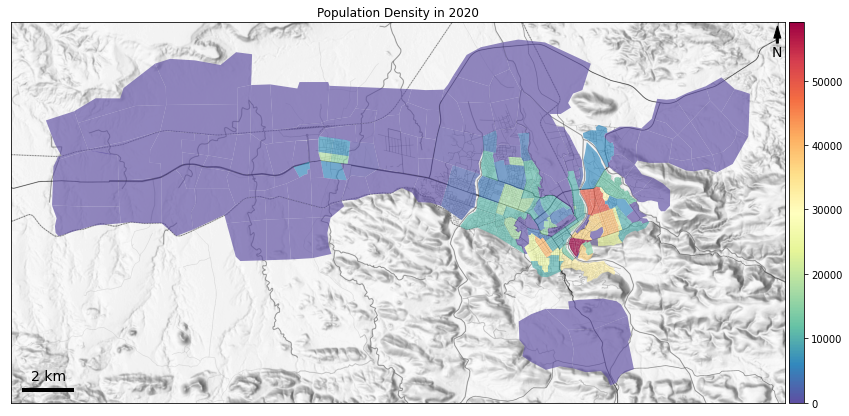

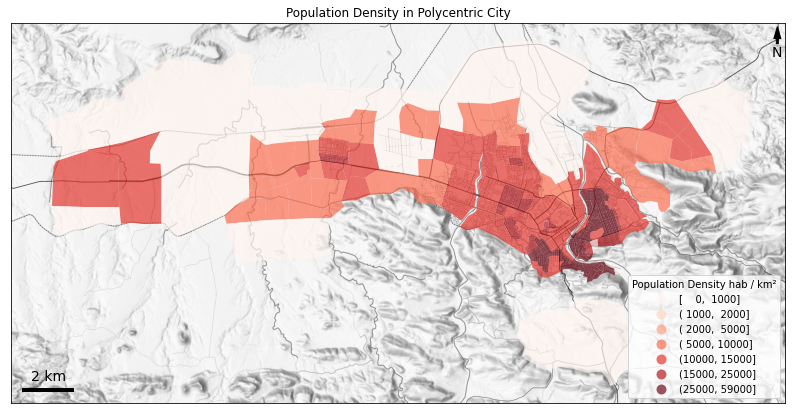

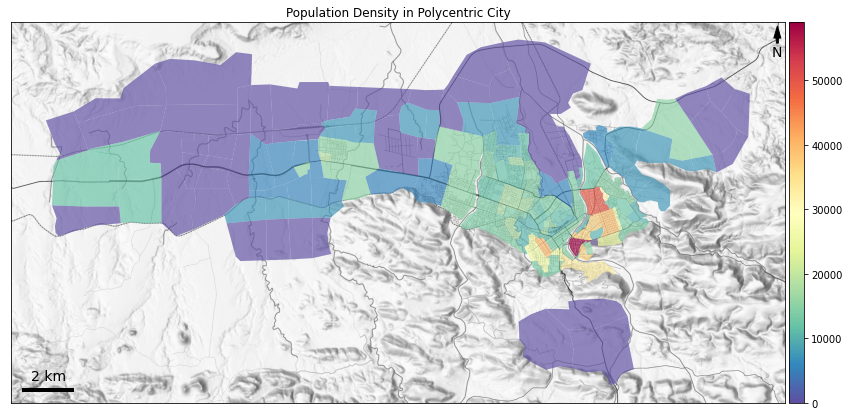

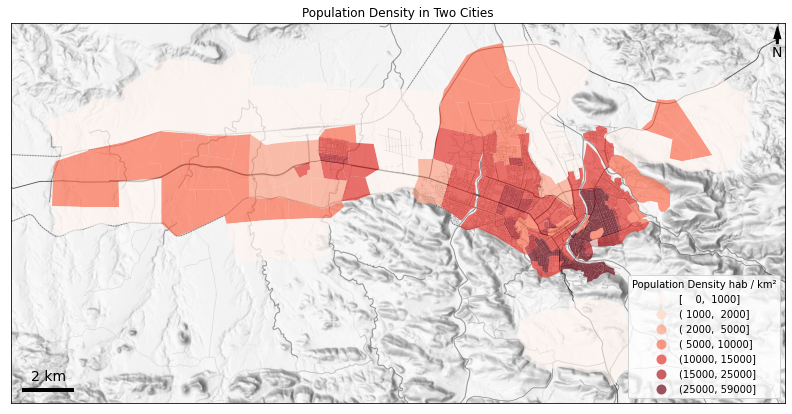

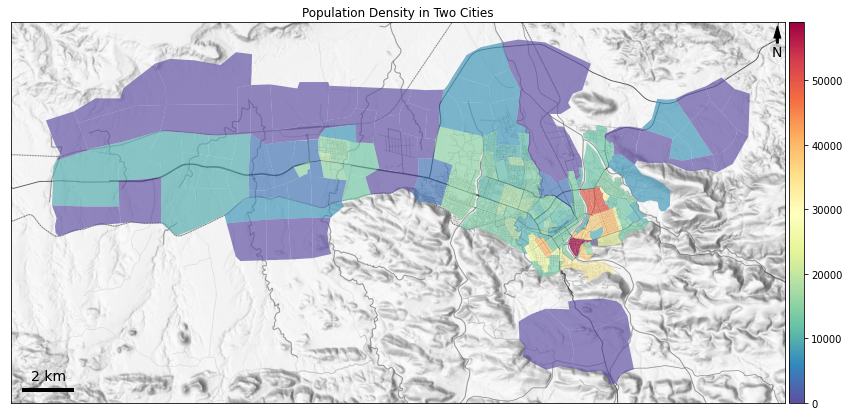

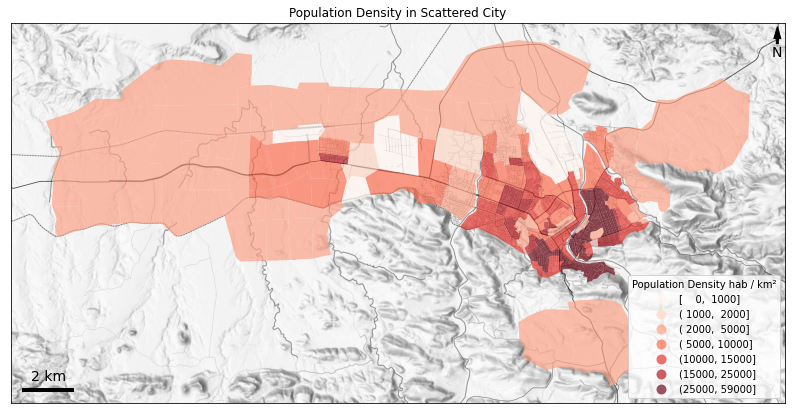

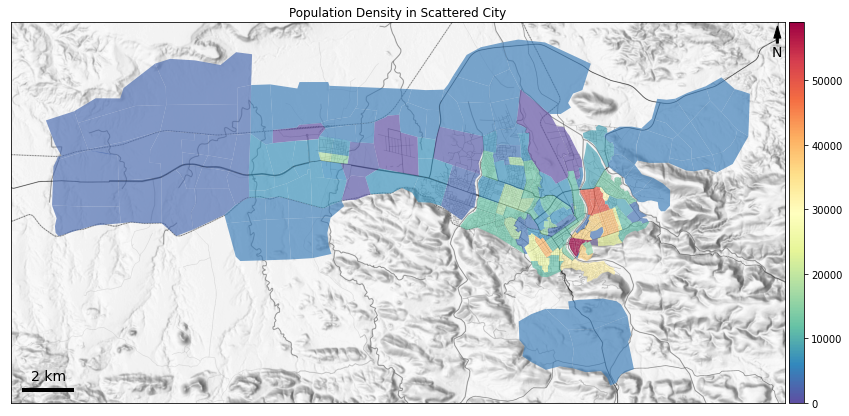

In [20]:
cmap = 'YlOrRd'
cmap = 'RdYlGn_r'
cmap = 'Reds'
if manual:
    for scen in ['2020', 'Polycentric City', 'Two Cities', 'Scattered City']:
        plot = plot_density(zones, column='Population Density ' + scen , cmap=cmap)
        plot.set_title('Population Density in ' + scen)
        plot.get_figure().savefig('../../outputs/population_density_class_' + scen + '.png', bbox_inches='tight')

        plot = plot_density(zones, column='Population Density ' + scen , cmap='Spectral_r', scheme=None)
        plot.set_title('Population Density in ' + scen)
        plot.get_figure().savefig('../../outputs/population_density_' + scen + '.png', bbox_inches='tight')

In [21]:
zones[['kebele_latin', 'latin_name']] = zones[['kebele_latin', 'latin_name']].applymap(format_string)

In [22]:
pa = pd.read_excel('../../inputs/production_attraction_zones.xlsx')
pa['latin_name'] = pa['latin_name'].apply(format_string)

In [23]:
zones.drop(['visit_estim', 'empl_estim'], axis=1, errors='ignore', inplace=True)
zones = pd.merge(zones, pa[['empl_estim', 'visit_estim', 'latin_name']], on='latin_name', how='left')

In [24]:
zones['Jobs 2020'] = zones['empl_estim'].fillna(0)
zones['Visits 2020'] = zones['visit_estim'].fillna(0)

In [25]:
zones['Population 2020'].fillna(0, inplace=True)

In [26]:
job_ratio = zones['Jobs 2020'].sum() / zones['Population 2020'].sum()
visit_ratio = zones['Visits 2020'].sum() / zones['Population 2020'].sum()

In [27]:
zones['type']

0      existing_high
1      existing_high
2      existing_high
3      existing_high
4      existing_high
           ...      
210             open
211             open
212             open
213             open
214             open
Name: type, Length: 215, dtype: object

In [28]:
for scen in ['2020', 'Polycentric City', 'Two Cities', 'Scattered City']:
    delta = zones['Population %s' % scen] - zones['Population 2020']
    zones['Visits %s' % scen] = zones['Visits 2020'] + delta * visit_ratio
    zones['Jobs %s' % scen] = zones['Jobs 2020'] + delta * job_ratio # erreur quentin 
    zones['Job Density %s' % scen] = zones['Jobs %s' % scen] / zones['area']
    zones['Visit Density %s' % scen] = zones['Visits %s' % scen] / zones['area']

In [29]:
zones[['type','Population Polycentric City', 'Population Density Polycentric City',
       'Population Two Cities', 'Population Density Two Cities',
       'Population Scattered City', 'Population Density Scattered City',
       'Jobs Polycentric City', 'Job Density Polycentric City',
       'Jobs Two Cities', 'Job Density Two Cities',
       'Jobs Scattered City', 'Job Density Scattered City']].groupby('type').sum()

Population Polycentric City  \
type                                           
existing_high                  377488.275588   
existing_low                   123466.724412   
existing_vacant                 60000.000000   
nip                            120000.000000   
open                           154121.000000   
reserved                            0.000000   

                 Population Density Polycentric City  Population Two Cities  \
type                                                                          
existing_high                                3038700          377488.275588   
existing_low                                  153300          119211.724412   
existing_vacant                                82500           36000.000000   
nip                                            35700          180000.000000   
open                                          198700          122375.000000   
reserved                                           0               0.000000   

                 Population Density Two Cities  Population Scattered City  \
type                                                                        
existing_high                          3026300              328397.275588   
existing_low                            149100               26915.724412   
existing_vacant                          51800               76563.000000   
nip                                     124800              120000.000000   
open                                    136800              283200.000000   
reserved                                     0                   0.000000   

                 Population Density Scattered City  Jobs Polycentric City  \
type                                                                        
existing_high                              2862000          122184.260714   
existing_low                                 67400           35639.321151   
existing_vacant                             107200           27183.879165   
nip                                          60900           40157.758329   
open                                        211500           51576.282262   
reserved                                         0            2715.000000   

                 Job Density Polycentric City  Jobs Two Cities  \
type                                                             
existing_high                    1.226701e+06    122184.260714   
existing_low                     3.418128e+04     34215.393970   
existing_vacant                  3.481154e+04     19152.327499   
nip                              1.197766e+04     60236.637494   
open                             6.634225e+04     40952.547296   
reserved                         1.533147e+03      2715.000000   

                 Job Density Two Cities  Jobs Scattered City  \
type                                                           
existing_high              1.222851e+06        105756.056430   
existing_low               3.280015e+04          3328.723447   
existing_vacant            2.499730e+04         32726.653758   
nip                        4.167893e+04         40157.758329   
open                       4.563845e+04         94772.309657   
reserved                   1.533147e+03          2715.000000   

                 Job Density Scattered City  
type                                         
existing_high                  1.167772e+06  
existing_low                   5.435725e+03  
existing_vacant                4.312924e+04  
nip                            2.054243e+04  
open                           7.148919e+04  
reserved                       1.533147e+03

In [30]:
zones[['type','Population Polycentric City',
       'Population Two Cities',
       'Population Scattered City',
       'Jobs Polycentric City',
       'Jobs Two Cities',
       'Jobs Scattered City']].groupby('type').sum()

Population Polycentric City  Population Two Cities  \
type                                                                  
existing_high                  377488.275588          377488.275588   
existing_low                   123466.724412          119211.724412   
existing_vacant                 60000.000000           36000.000000   
nip                            120000.000000          180000.000000   
open                           154121.000000          122375.000000   
reserved                            0.000000               0.000000   

                 Population Scattered City  Jobs Polycentric City  \
type                                                                
existing_high                328397.275588          122184.260714   
existing_low                  26915.724412           35639.321151   
existing_vacant               76563.000000           27183.879165   
nip                          120000.000000           40157.758329   
open                         283200.000000           51576.282262   
reserved                          0.000000            2715.000000   

                 Jobs Two Cities  Jobs Scattered City  
type                                                   
existing_high      122184.260714        105756.056430  
existing_low        34215.393970          3328.723447  
existing_vacant     19152.327499         32726.653758  
nip                 60236.637494         40157.758329  
open                40952.547296         94772.309657  
reserved             2715.000000          2715.000000

In [31]:
for shape in 'Two Cities', 'Scattered City', 'Polycentric City':
    print ('Population ',shape,zones['Population '+shape].sum())
    print ('Jobs ',shape,zones['Jobs '+shape].sum())

Population  Two Cities 835075.0
Jobs  Two Cities 279456.166973419
Population  Scattered City 835076.0
Jobs  Scattered City 279456.501621405
Population  Polycentric City 835076.0
Jobs  Polycentric City 279456.501621405


In [32]:
to_drop = [
    'Name', 'description', 'timestamp', 'begin', 'end', 'altitudeMode',
    'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon',
    'kebele_amharic', 'amharic_name', 'amharic_code','amharic', 'description',
    'sample',
    
]
zones['zone_index'] = ['zone_' + str(i) for i in zones.index]
zones['id'] = zones['kebele_latin'].fillna(zones['zone_index'])
zones.drop(
    to_drop
    , axis=1
).to_file('../../inputs/zones/zones_with_population_2040.geojson', driver='GeoJSON')

# COMPARISONS

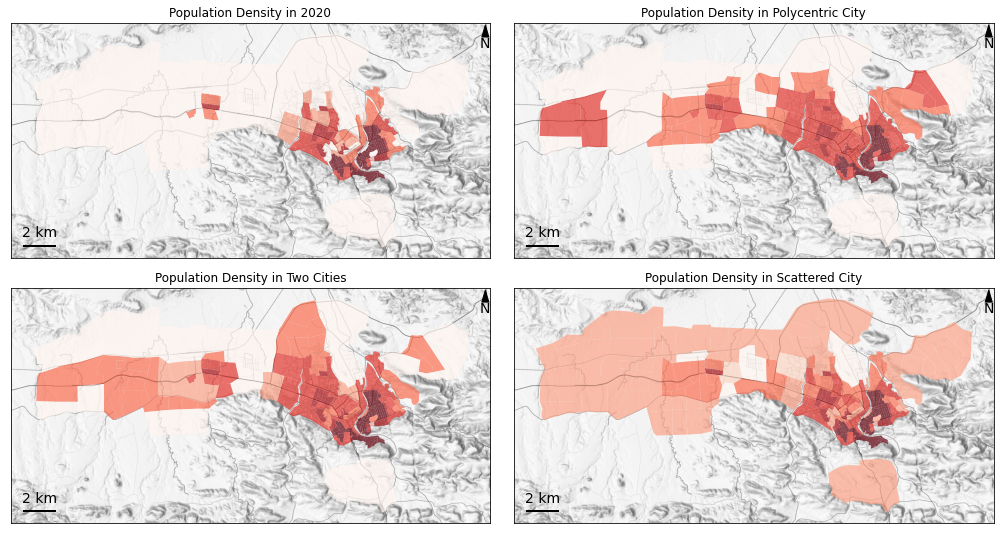

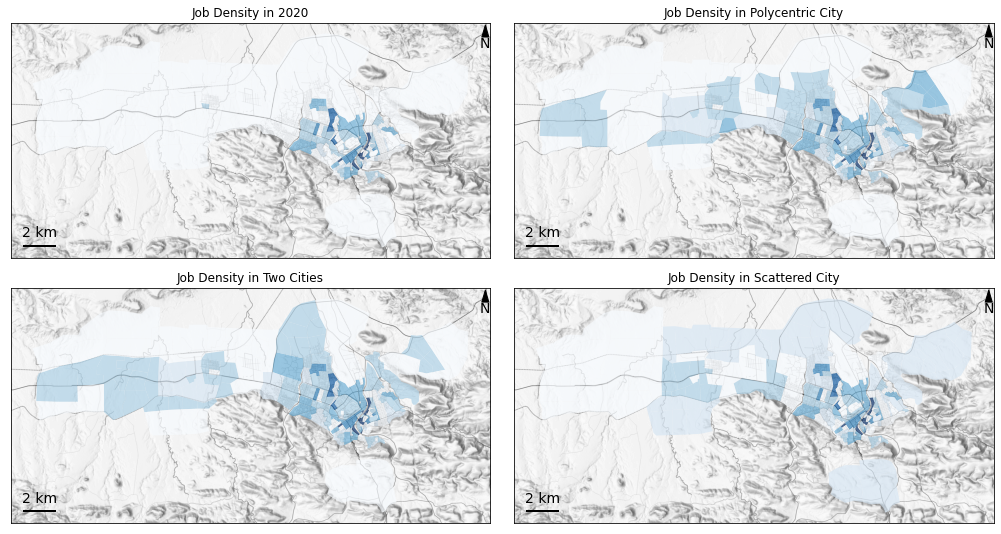

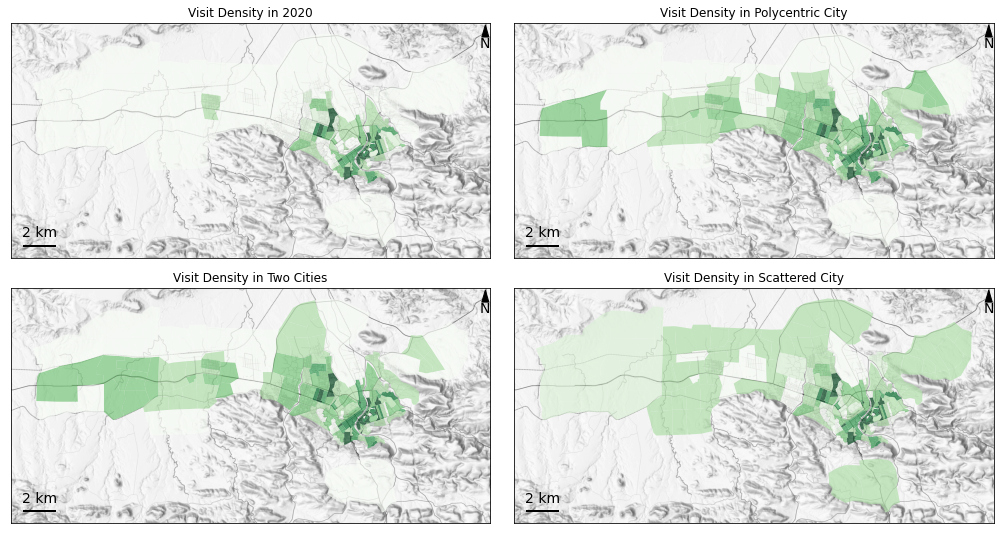

In [33]:
import matplotlib.pyplot as plt
if manual:
    for column, cmap in [('Population', 'Reds'), ('Job', 'Blues'), ('Visit', 'Greens')]:
        rows = columns = 2
        fig, axes = plt.subplots(2, 2, figsize=[25, 25])
        fig.constrained_layout=True
        i = 0
        for scen in ['2020', 'Polycentric City', 'Two Cities', 'Scattered City']:

            plot = plot_density(
                zones, column=column + ' Density ' + scen , cmap=cmap, 
                ax=fig.get_axes()[i], legend=False,
                               )
            plot.set_title(column + ' Density in ' + scen)
            i +=1

        ax = fig.get_axes()[0]
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.set_size_inches(bbox.width*columns, rows*(bbox.height)*1.1)
        fig.subplots_adjust(wspace=0.05, hspace=0.05)

        fig.savefig('../../outputs/%s_density'%column.lower() + '_comparison' + '.png', bbox_inches='tight')